# Capstone Project - Deposits Expenses Prediction for a Financial Institution

In [209]:
import numpy as np
import pandas as pd
import random

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

### DEPOSITS DATASET - MOCK DATA GENERATION

In [204]:
seed_value = 12
np.random.seed(seed_value)
random.seed(seed_value)

# Generate daily balance data
start_date = '2018-06-01'
end_date = '2023-06-30'
dates = pd.date_range(start=start_date, end=end_date, freq='D')
num_days = len(dates)
num_clients = 50

# Initialize each client's initial balance
initial_balances = {client_id: np.random.randint(1000, 50000) for client_id in range(1, num_clients + 1)}

# Create DataFrame to store daily balance
balance_data = []
for date in dates:
    for client_id in range(1, num_clients + 1):
        balance = initial_balances[client_id]
        
        # Apply cash flows based on client category
        if 1 <= client_id <= 15:
            cash_flow_range = (-50, 100)
        elif 16 <= client_id <= 25:
            cash_flow_range = (-400, 500)
        elif 26 <= client_id <= 37:
            cash_flow_range = (-1000, 2000)
        elif 38 <= client_id <= 45:
            cash_flow_range = (-1300, 2400)
        elif 46 <= client_id <= 50:
            cash_flow_range = (-2000, 3000)
            
        cash_flow = np.random.uniform(cash_flow_range[0], cash_flow_range[1])
        balance += cash_flow
        
        balance_data.append((date, balance, client_id))

balance_dataset = pd.DataFrame(balance_data, columns=['Date', 'Balance', 'Client ID'])

balance_dataset = balance_dataset.sort_values(by=['Client ID', 'Date'])

# Create additional columns
balance_dataset['Category'] = 'Ending Balance'
balance_dataset['Currency'] = 'EUR'

balance_dataset = balance_dataset.reset_index(drop=True)
balance_dataset.head()

,Date,Balance,Client ID,Category,Currency
0,2018-06-01,15154.14,1,Ending Balance,EUR
1,2018-06-02,15234.37,1,Ending Balance,EUR
2,2018-06-03,15115.16,1,Ending Balance,EUR
3,2018-06-04,15237.39,1,Ending Balance,EUR
4,2018-06-05,15148.73,1,Ending Balance,EUR


### DATA CLEAN UP AND DATA PREP

In [205]:
balance_dataset = balance_dataset.groupby(['Date', 'Category', 'Currency'], as_index=False)['Balance'].sum()

pd.options.display.float_format = '{:.2f}'.format


In [206]:
balance_dataset_ts = balance_dataset

balance_dataset_ts['Date'] = pd.to_datetime(balance_dataset_ts['Date'])

balance_dataset_ts.set_index('Date', inplace=True)
balance_dataset_ts.sort_index(inplace=True)

balance_dataset_ts.head()

,Category,Currency,Balance
Date,,,
2018-06-01,Ending Balance,EUR,1148735.55
2018-06-02,Ending Balance,EUR,1149305.10
2018-06-03,Ending Balance,EUR,1157184.22
2018-06-04,Ending Balance,EUR,1148017.08
2018-06-05,Ending Balance,EUR,1147182.99


### GRID SEARCH - AUTO ARIMA

In [207]:
# Grid search to determine the optimal ARIMA parameters
model = auto_arima(balance_dataset_ts['Balance'], seasonal=False, stepwise=False, suppress_warnings=True)

print(model)

 ARIMA(3,0,1)(0,0,0)[0]          


### MODEL - TIME SERIES

In [208]:
# Fit the selected model
model_fit = model.fit(balance_dataset_ts['Balance'])

# Calculate RMSE
y_true = balance_dataset_ts['Balance'].iloc[-1]  # Actual balance for the next day
rmse = mean_squared_error([y_true], next_day_prediction, squared=False)

# Predict the future balance for the next day
next_day_date = balance_dataset_ts.index[-1] + pd.DateOffset(days=1)
next_day_prediction = model_fit.predict(n_periods=1)

# Create a new DataFrame with the old data and the new row
new_row = pd.DataFrame({
    'Category': ['Future Balance'],
    'Currency': ['EUR'],
    'Balance': [next_day_prediction[0]]
}, index=[next_day_date])

new_dataset = pd.concat([balance_dataset_ts, new_row])

print("RMSE:", rmse)
print("Predicted Next Day Deposits Balance:", next_day_prediction[0])

new_dataset

RMSE: 5123.926645182073
Predicted Next Day Deposits Balance: 1150913.7454960002


,Category,Currency,Balance
2018-06-01,Ending Balance,EUR,1148735.55
2018-06-02,Ending Balance,EUR,1149305.10
2018-06-03,Ending Balance,EUR,1157184.22
2018-06-04,Ending Balance,EUR,1148017.08
2018-06-05,Ending Balance,EUR,1147182.99
...,...,...,...
2023-06-27,Ending Balance,EUR,1152346.72
2023-06-28,Ending Balance,EUR,1158844.43
2023-06-29,Ending Balance,EUR,1149562.83
2023-06-30,Ending Balance,EUR,1145789.82


### ANALYTICAL GRAPH

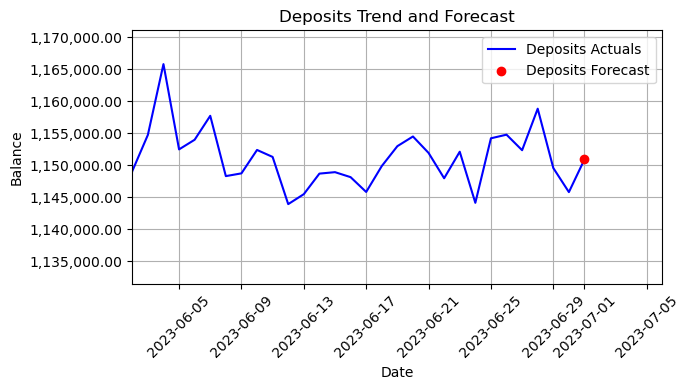

In [124]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(new_dataset.index, new_dataset['Balance'], color='blue', label='Deposits Actuals')
future_balance = new_dataset[new_dataset['Category'] == 'Future Balance']
ax.scatter(future_balance.index, future_balance['Balance'], color='red', label='Deposits Forecast', zorder=5)
ax.set_title('Deposits Trend and Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Balance')
ax.legend()
ax.grid(True)
previous_30_days = new_dataset.index[-30:]
next_5_days = pd.date_range(start=new_dataset.index[-1] + pd.DateOffset(days=1), periods=5, freq='D')
ax.set_xlim(previous_30_days[0], next_5_days[-1])
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

plt.tight_layout()
plt.show()

### DATA SOURCE, CLEAN UP AND DATA PREP

In [201]:
# Read the CSV file into a DataFrame
csv_file_path = "ECB Data Portal_20230810135021.csv"
eur_rate = pd.read_csv(csv_file_path)

eur_rate.rename(columns={'Euro short-term rate - Volume-weighted trimmed mean rate (EST.B.EU000A2X2A25.WT)': 'EUR RATE'}, inplace=True)

eur_rate.drop(columns=['TIME PERIOD'], inplace=True)

# Shift 'EUR RATE' column to get the next day's rate
eur_rate['Next Day EUR RATE'] = eur_rate['EUR RATE'].shift(-1)

# Drop rows with missing values (last row)
eur_rate.dropna(inplace=True)

eur_rate

,DATE,EUR RATE,Next Day EUR RATE
0,2019-10-01,-0.55,-0.55
1,2019-10-02,-0.55,-0.56
2,2019-10-03,-0.56,-0.55
3,2019-10-04,-0.55,-0.55
4,2019-10-07,-0.55,-0.55
...,...,...,...
957,2023-06-23,3.40,3.40
958,2023-06-26,3.40,3.40
959,2023-06-27,3.40,3.40
960,2023-06-28,3.40,3.40


### GRID SEARCH

In [197]:
# Separate features (X) and target (y)
X = eur_rate[['EUR RATE']]
y = eur_rate['Next Day EUR RATE']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search
model = LinearRegression()
param_grid = {'fit_intercept': [True, False], 'copy_X': [True, False]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


### MODEL LINEAR REGRESSION

In [199]:
# Predict the EUR rates on the test data using the best model
y_pred = best_model.predict(X_test)

# Calculate metrics: Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model Mean Squared Error:", mse)
print("Best Model R-squared:", r2)

# Predict the next day's EUR rate:
last_day_rate = eur_rate['EUR RATE'].iloc[-1]
next_day_rate_prediction = best_model.predict([[last_day_rate]])
print("Predicted Next Day EUR Rate using Best Model:", next_day_rate_prediction[0])

Best Model Mean Squared Error: 0.007288764975537957
Best Model R-squared: 0.9948135479978905
Predicted Next Day EUR Rate using Best Model: 3.411270557881059


# FINAL RESULTS

In [200]:
# Calculate the Projected Expense:
projected_expense = [pred * rate / 12 for pred, rate in zip(next_day_prediction, next_day_rate_prediction)]


# Create a Final DataFrame with projected values:
projected_data = {
    'DATE': [next_day_date],
    'PROJECTED BALANCE': [next_day_prediction[0]],
    'PROJECTED RATE': [next_day_rate_prediction[0]],
    'PROJECTED EXPENSE': [projected_expense[0]]
}
projected_df = pd.DataFrame(projected_data)

projected_df

,DATE,PROJECTED BALANCE,PROJECTED RATE,PROJECTED EXPENSE
0,2023-07-01,1150913.75,3.41,327173.18
